# Plotting utilities

`xarrayutils` provides a bunch of small functions to adjust [matplotlib](https://matplotlib.org) plots.

## Setting multiple y axes to the same values range
Sometimes it is beneficial if the amplitude of a signal can be compared directly. If the mean of the signal is shifted, setting the absolute y limits doesnt work. `same_y_range` provides a quick fix.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

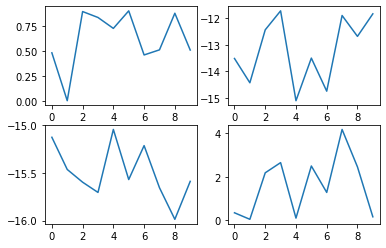

In [2]:
fig, axarr = plt.subplots(ncols=2, nrows=2)

# plot the same signal scaled and shifted or both
axarr.flat[0].plot(np.random.rand(10))
axarr.flat[1].plot((np.random.rand(10)*5)-16)
axarr.flat[2].plot((np.random.rand(10))-16)
axarr.flat[3].plot((np.random.rand(10)*5))


These are hard to compare with regard to their amplitude. 

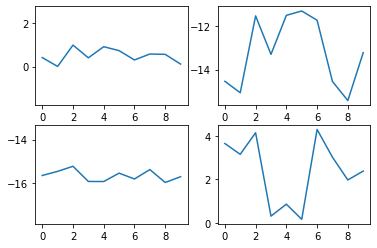

In [3]:
from xarrayutils.plotting import same_y_range

fig, axarr = plt.subplots(ncols=2, nrows=2)

# plot the same signal scaled and shifted or both
axarr.flat[0].plot(np.random.rand(10))
axarr.flat[1].plot((np.random.rand(10)*5)-16)
axarr.flat[2].plot((np.random.rand(10))-16)
axarr.flat[3].plot((np.random.rand(10)*5))

same_y_range(axarr)

Now we can clearly see the different amplitude. 

## shaded line plots

In [4]:
from xarrayutils.plotting import shaded_line_plot

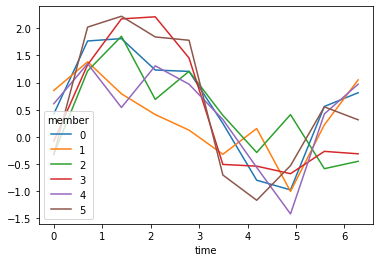

In [22]:
# build test dataset with noisy members
import xarray as xr
import matplotlib
import pytest

x = np.linspace(0,2*np.pi, 10)
y = np.sin(x)
y_full = np.stack([y+np.random.rand(len(y))*2-0.5 for e in range(6)])
da = xr.DataArray(y_full, coords=[('member',range(6)),('time',x)])
da.plot(hue='member');

Thats pretty cool (xarray is generally awesome!), but what if we have several of these datasets (e.g. climate models with several members each)?

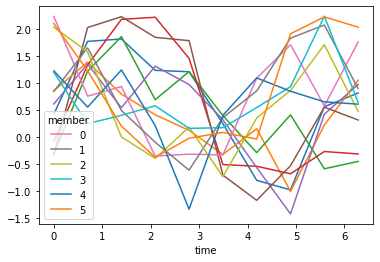

In [23]:
x = np.linspace(0,2*np.pi, 10)
y = np.sin(x+2)
y_full = np.stack([y+np.random.rand(len(y))*2-0.5 for e in range(6)])
da2 = xr.DataArray(y_full, coords=[('member',range(6)),('time',x)])
da.plot(hue='member')
da2.plot(hue='member');

Ok that is not great. We can color each dataset with a different color...

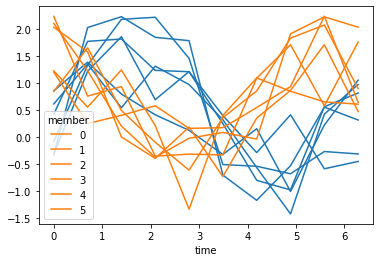

In [79]:
da.plot(hue='member', color='C0')
da2.plot(hue='member', color='C1');

But if you supply more models this ends up looking too busy. `xarrayutils.plotting.shaded_line_plot` give a quick alternative to show the spread of the members with a line and shaded envelope:

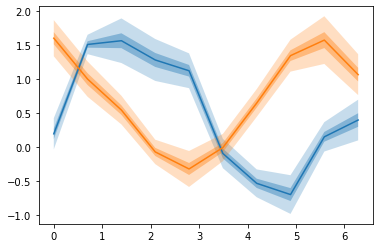

In [41]:
shaded_line_plot(da, 'member', color='C0');
shaded_line_plot(da2, 'member', color='C1');

In the default setting, this plots the mean along the dimension `member` as a line and the ranges indicate 1 standard deviation (dark shading) and 3 standard deviations (light shading). The transparency and spread values can be customized.

Lets add shading for 2, 3, and 5 standard deviations with different increasing alpha values (increasing alpha for increased transparency).

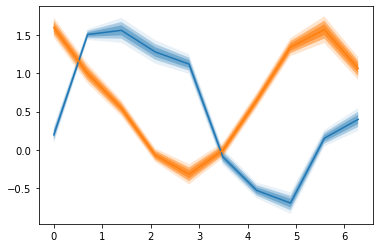

In [73]:
shaded_line_plot(da, 'member', spreads=[2,3,5], alphas=[0.1, 0.3, 0.4], color='C0');
shaded_line_plot(da2, 'member',spreads=[2,3,5], alphas=[0.2, 0.5, 0.6], color='C1');

Additionally `shaded_line_plot` offers a different mode to determine the spread, using quantiles.

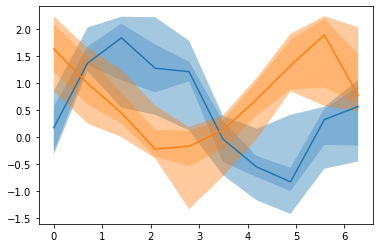

In [78]:
shaded_line_plot(da, 'member', spread_style='quantile', spreads=[0.5,1], alphas=[0.3, 0.4], color='C0');
shaded_line_plot(da2, 'member',spread_style='quantile', spreads=[0.5,1], alphas=[0.3, 0.4], color='C1');

Here the lines indicate the 50th quantile (approximate median), and the shadings indicate the range between the 25th and 75th percentile (dark) and the full range between 0th and 100th percentile (light